In [2]:
import numpy as np, pandas as pd
# Load & basic cleaning
df = pd.read_csv("diamonds.csv")
df = df.drop_duplicates()

In [3]:
df['volume'] = df['x'] * df['y'] * df['z']
df['price_per_carat'] = df['price'] / df['carat']

# Dimension Ratio = (x + y) / (2 * z)
df['dimension_ratio'] = (df['x'] + df['y']) / (2 * df['z'])

# Carat Category: Light (<0.5), Medium (0.5-1.5), Heavy (>1.5)
conditions = [
    df['carat'] < 0.5,
    (df['carat'] >= 0.5) & (df['carat'] <= 1.5),
    df['carat'] > 1.5
]
choices = ['Light', 'Medium', 'Heavy']
# use default=None so np.select returns an object array (avoids mixing string and float dtypes)
df['carat_category'] = pd.Categorical(
    np.select(conditions, choices, default=None),
    categories=choices,
    ordered=True
)


In [4]:
print(df.head)

<bound method NDFrame.head of        carat        cut color clarity  depth  table  price     x     y     z  \
0       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
1       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
2       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
3       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
4       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3.50   
53936   0.72       Good     D     SI1   63.1   55.0   2757  5.69  5.75  3.61   
53937   0.70  Very Good     D     SI1   62.8   60.0   2757  5.66  5.68  3.56   
53938   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74   
53939   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   

         

In [5]:
numeric_features = ['carat', 'depth', 'table', 'volume', 'price_per_carat','dimension_ratio']
cat_cols = ['cut', 'color', 'clarity', 'carat_category']

# Ordinal mappings
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = list("JIHGFED")[::-1]  # -> ['D','E','F','G','H','I','J']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
carat_order=['Light','Medium','Heavy']

cut_mapping = {v: i for i, v in enumerate(cut_order)}
color_mapping = {v: i for i, v in enumerate(color_order)}
clarity_mapping = {v: i for i, v in enumerate(clarity_order)}
carat_mapping={v: i for i, v in enumerate(carat_order)}

# Apply mapping
df['cut_encoded'] = df['cut'].map(cut_mapping)
df['color_encoded'] = df['color'].map(color_mapping)
df['clarity_encoded'] = df['clarity'].map(clarity_mapping)
df['carat_encoded']=df['carat_category'].map(carat_mapping)


In [6]:
print(df.columns)

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z', 'volume', 'price_per_carat', 'dimension_ratio', 'carat_category',
       'cut_encoded', 'color_encoded', 'clarity_encoded', 'carat_encoded'],
      dtype='object')


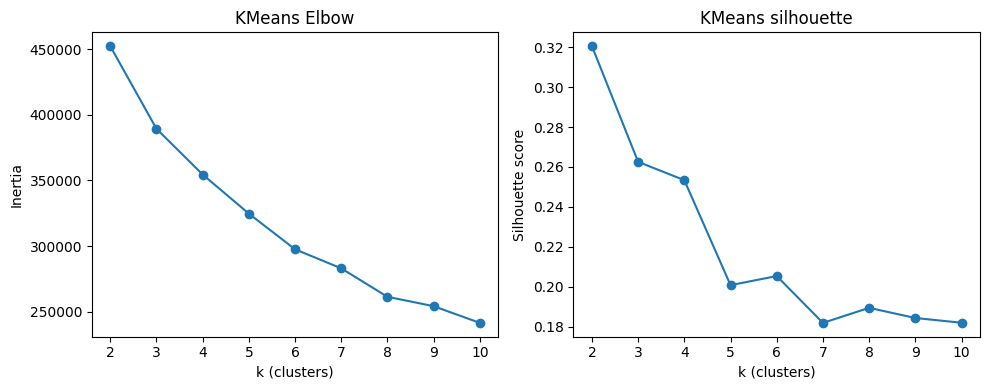

In [7]:
# Clustering experiments: KMeans, DBSCAN, Agglomerative — evaluate with Silhouette/Elbow, visualize with PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

# Prepare data for clustering: drop price
clu_df = df.drop(columns=['price','cut', 'color', 'clarity', 'carat_category']).copy()
'''# Ensure derived features exist
for col in ['volume','dimension_ratio','price_per_carat','carat_category']:
    if col not in clu_df.columns and col == 'volume':
        clu_df['volume'] = clu_df['x'] * clu_df['y'] * clu_df['z']
    if col not in clu_df.columns and col == 'dimension_ratio':
        clu_df['dimension_ratio'] = (clu_df['x'] + clu_df['y']) / (2 * clu_df['z'])
    if col not in clu_df.columns and col == 'price_per_carat' and 'price' in df.columns:
        clu_df['price_per_carat'] = df['price'] / df['carat']

# Encode categorical variables via one-hot to avoid implicit ordering
cat_cols = ['cut','color','clarity','carat_category']
for c in cat_cols:
    if c in clu_df.columns:
        clu_df[c] = clu_df[c].astype('category')

clu_enc = pd.get_dummies(clu_df, columns=[c for c in cat_cols if c in clu_df.columns], drop_first=False)
'''
# Fill missing and scale
clu_df = clu_df.replace([np.inf, -np.inf], np.nan)
clu_df = clu_df.apply(pd.to_numeric, errors='coerce')  
clu_df = clu_df.fillna(clu_df.median())
scaler = StandardScaler()
X = scaler.fit_transform(clu_df)

# PCA for visualization (2D)
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)

# 1) KMeans: Elbow (inertia) and silhouette
ks = list(range(2, 11))
inertias = []
sil_scores_k = []
kmeans_models = {}
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil = silhouette_score(X, labels) #if len(np.unique(labels)) > 1 else np.nan
    sil_scores_k.append(sil)
    kmeans_models[k] = (km, sil)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, '-o')
plt.xlabel('k (clusters)')
plt.ylabel('Inertia')
plt.title('KMeans Elbow')

plt.subplot(1,2,2)
plt.plot(ks, sil_scores_k, '-o')
plt.xlabel('k (clusters)')
plt.ylabel('Silhouette score')
plt.title('KMeans silhouette')
plt.tight_layout()
plt.show()

In [9]:
display(clu_df)
display(X)

,carat,depth,table,x,y,z,volume,price_per_carat,dimension_ratio,cut_encoded,color_encoded,clarity_encoded,carat_encoded
0,0.23,61.5,55.0,3.95,3.98,2.43,38.202030,1417.391304,1.631687,4,1,1,0
1,0.21,59.8,61.0,3.89,3.84,2.31,34.505856,1552.380952,1.673160,3,1,2,0
2,0.23,56.9,65.0,4.05,4.07,2.31,38.076885,1421.739130,1.757576,1,1,4,0
3,0.29,62.4,58.0,4.20,4.23,2.63,46.724580,1151.724138,1.602662,3,5,3,0
4,0.31,63.3,58.0,4.34,4.35,2.75,51.917250,1080.645161,1.580000,1,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,5.75,5.76,3.50,115.920000,3829.166667,1.644286,4,0,2,1
53936,0.72,63.1,55.0,5.69,5.75,3.61,118.110175,3829.166667,1.584488,1,0,2,1
53937,0.70,62.8,60.0,5.66,5.68,3.56,114.449728,3938.571429,1.592697,2,0,2,1
53938,0.86,61.0,58.0,6.15,6.12,3.74,140.766120,3205.813953,1.640374,3,4,1,1


array([[-1.19940227, -0.17349495, -1.10048556, ..., -0.93698968,
        -1.24597322, -1.26011152],
       [-1.2416511 , -1.36239274,  1.58569074, ..., -0.93698968,
        -0.63875021, -1.26011152],
       [-1.19940227, -3.39051249,  3.37647494, ..., -0.93698968,
         0.57569582, -1.26011152],
       ...,
       [-0.20655466,  0.73566218,  1.13799469, ..., -1.52484434,
        -0.63875021,  0.36921352],
       [ 0.13143602, -0.52317077,  0.24260259, ...,  0.82657432,
        -1.24597322,  0.36921352],
       [-0.10093257,  0.31605119, -1.10048556, ..., -1.52484434,
        -1.24597322,  0.36921352]], shape=(53794, 13))

In [19]:
display(max(kmeans_models.items(), key=lambda kv: (kv[1][1] if np.isfinite(kv[1][1]) else -999))[0])

2

In [20]:
best_model = KMeans(n_clusters=3, random_state=42, n_init='auto').fit(X)
labels = best_model.labels_

In [34]:
# Save trained model (pickle)
import pickle
import os

model_path = "kmeans_best_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print(f"Saved model to {model_path}")

# Optionally save scaler as an artifact for future preprocessing
artifacts_path = "kmeans_artifacts.pkl"
artifacts = {"scaler": scaler}
with open(artifacts_path, "wb") as f:
    pickle.dump(artifacts, f)
print(f"Saved artifacts to {artifacts_path}")

# Quick verification: load the model back and compare
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)
print("Loaded model type:", type(loaded_model))
print("n_clusters:", getattr(loaded_model, "n_clusters", None))
# verify labels exist and match
if hasattr(loaded_model, 'labels_'):
    print("labels match:", (loaded_model.labels_ == best_model.labels_).all())
else:
    print("Loaded model has no labels_ attribute (may need to call .fit on it after loading).")


Saved model to kmeans_best_model.pkl
Saved artifacts to kmeans_artifacts.pkl
Loaded model type: <class 'sklearn.cluster._kmeans.KMeans'>
n_clusters: 3
labels match: True


In [26]:
display(labels)

array([2, 2, 2, ..., 1, 1, 1], shape=(53794,), dtype=int32)

In [21]:
# Attach cluster labels to original df (including price for analysis)
df_clusters = df.copy()
df_clusters['cluster'] = labels

# Characterize clusters
summary = df_clusters.groupby('cluster').agg(
    count=('price','size'),
    mean_price=('price','mean'),
    mean_carat=('carat','mean')
).sort_values('mean_price', ascending=False)

# Top cut per cluster
top_cut = df_clusters.groupby('cluster')['cut'].agg(lambda s: s.mode().iloc[0] if len(s)>0 else np.nan)
summary['top_cut'] = top_cut

# Naming heuristic
global_price = df_clusters['price'].mean()
global_carat = df_clusters['carat'].mean()

def name_cluster(row):
    if row['mean_price'] > global_price and row['mean_carat'] > global_carat:
        return 'Premium Heavy Diamonds'
    if row['mean_price'] < global_price and row['mean_carat'] < global_carat:
        return 'Affordable Small Diamonds'
    return 'Mid-range Balanced Diamonds'

summary['name'] = summary.apply(name_cluster, axis=1)

display(summary)

,count,mean_price,mean_carat,top_cut,name
cluster,,,,,
0,6632,12226.009047,1.738239,Premium,Premium Heavy Diamonds
1,22836,4595.258452,0.950709,Ideal,Premium Heavy Diamonds
2,24326,1050.525734,0.397821,Ideal,Affordable Small Diamonds


In [ ]:
c_n_dict ={0:"Premium Heavy Diamonds",1:"Mid-range Balanced Diamonds",2:"Affordable Small Diamonds"
}

#summary['n_n']= df_clusters['cluster'].map(c_n_dict)
#name_for_pred = c_n_dict.get(labels, 'Unknown / Noise')


# 1) list comprehension (explicit, simple)
name_for_pred = [c_n_dict.get(int(l), 'Unknown / Noise') for l in labels]

# 2) pandas mapping (vectorized, convenient)
#name_for_pred = pd.Series(labels).map(c_n_dict).fillna('Unknown / Noise').to_numpy()

# attach to dataframe


In [ ]:
# attach to dataframe
df_clusters['cluster_name'] = pd.Series(labels).map(c_n_dict).fillna('Unknown / Noise').values


,cluster_name,cluster
0,Affordable Small Diamonds,2
1,Affordable Small Diamonds,2
2,Affordable Small Diamonds,2
3,Affordable Small Diamonds,2
4,Affordable Small Diamonds,2
...,...,...
53935,Mid-range Balanced Diamonds,1
53936,Mid-range Balanced Diamonds,1
53937,Mid-range Balanced Diamonds,1
53938,Mid-range Balanced Diamonds,1


In [33]:
result = df_clusters[(df_clusters["cluster"] == 0 ) ][['cluster_name','cluster']]
print(result)


#display(df_clusters[['cluster_name','cluster']])

                 cluster_name  cluster
2024   Premium Heavy Diamonds        0
3926   Premium Heavy Diamonds        0
3955   Premium Heavy Diamonds        0
4128   Premium Heavy Diamonds        0
4970   Premium Heavy Diamonds        0
...                       ...      ...
27747  Premium Heavy Diamonds        0
27748  Premium Heavy Diamonds        0
27749  Premium Heavy Diamonds        0
48410  Premium Heavy Diamonds        0
49189  Premium Heavy Diamonds        0

[6632 rows x 2 columns]


In [28]:
display(summary)
display(labels, name_for_pred)

,count,mean_price,mean_carat,top_cut,name,n_n
cluster,,,,,,
0,6632,12226.009047,1.738239,Premium,Premium Heavy Diamonds,Affordable Small Diamonds
1,22836,4595.258452,0.950709,Ideal,Premium Heavy Diamonds,Affordable Small Diamonds
2,24326,1050.525734,0.397821,Ideal,Affordable Small Diamonds,Affordable Small Diamonds


array([2, 2, 2, ..., 1, 1, 1], shape=(53794,), dtype=int32)

['Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordable Small Diamonds',
 'Affordab

In [10]:
import pickle
with open("scaler.pkl", "wb") as f:   
    pickle.dump(scaler, f)